# Simple Physical Models for the Global 21-cm Signal

To begin, first import ares and a few standards

In [1]:
%matplotlib inline
import ares
import numpy as np
import matplotlib.pyplot as plt

To generate a model of the global 21-cm signal, we need to first assemble a set of appropriate parameters. The simplest models include prescriptions for the ionizing, Lyman-Werner / Lyman-$\alpha$, and X-ray emission from early galaxies. So, we'll construct a three population model -- one for each relevant emission band -- with independent parameters for the amount of radiation in each band. Later, we'll build models where the emission in different bands are connected by a physically-motivated model for galaxy SEDs.

For the time being, we'll also treat galaxies only in aggregate, i.e., no halo mass-dependent star formation efficiencies, escape fractions, etc., which means we're using the `GalaxyAggregate` approach (see :doc:example_galaxies_demo).

There's a parameter bundle that describes this exact set of choices, `global_signal:basic`, to get us started:

In [2]:
pars = ares.util.ParameterBundle('global_signal:basic')

If you print out the contents of this dictionary, you'll notice that there are a bunch of parameters, and what might stand out is that the identifiers `{0}`, `{1}`, and `{2}` appear in them. These indicate the three different source populations, one for ionizing UV, one for LW/Ly-$\alpha$, and one for X-rays. In general, different source populations are allowed to have different star formation properties (e.g., PopII vs. PopIII), but here the populations all share a common star formation rate density.

If you're a pre-version-1.0 ARES user, you might be wondering where the parameters `Nion`, `Nlw`, and `fX` have gone. Long story short, they are gone! We now require the parameters defining source populations to start with the prefix `pop_`, and we use the parameter `pop_rad_yield` to quantify the radiative output of any source population, regardless of the emission band. So, the outputs are now governed by:

- `pop_rad_yield{0}`: soft UV photons (10.2 - 13.6 eV) emitted per stellar baryon.
- `pop_rad_yield{1}`: X-ray luminosity per star formation rate, $L_X/\rm{SFR}$, in $\rm{erg} \ \rm{s}^{-1} \ (M_{\odot} / yr)^{-1}$.
- `pop_rad_yield{2}`: ionizing photons emitted per stellar baryon.

You'll notice also that `pop_sfr_model{0}='fcoll'`, meaning the cosmic star formation rate density (SFRD) is related to the rate at which matter collapses into dark matter halos. The only free parameters are the star formation effieciency, `pop_fstar{0}`, and the minimum virial temperature by default, `pop_Tmin{0}`. The SFRD of source populations `1` and `2` are linked to avoid re-computing three times, i.e., `pop_sfr_model{1}='link:sfrd:0'`.

Let's go ahead and run the model. First, we'll initialize the `Simulation` class:

In [3]:
sim = ares.simulations.Simulation(**pars)

The source populations are stored internally as separate objects, and are accessible in `sim.pops`. For example, we could have a look at the SFRD via

# Loaded $ARES/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.
# Loaded $ARES/halos/halo_mf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


Text(0, 0.5, '$\\dot{\\rho}_{\\ast} \\ [M_{\\odot} \\ \\mathrm{yr}^{-1} \\ \\mathrm{cMpc}^{-3}]$')

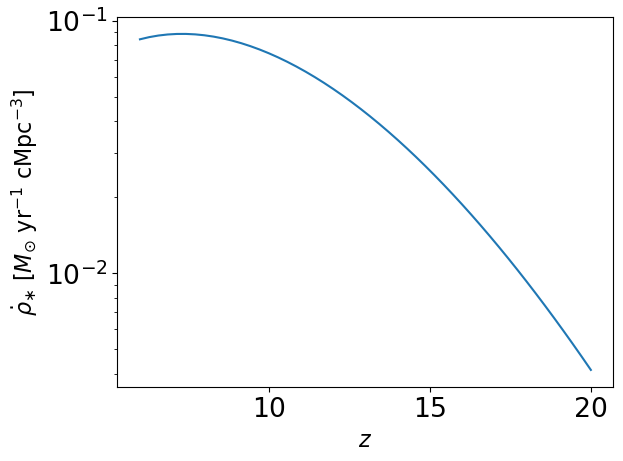

In [4]:
zarr = np.linspace(6, 20)
plt.semilogy(zarr, sim.pops[0].get_sfrd(zarr))
plt.xlabel(r'$z$')
plt.ylabel(ares.util.labels['sfrd'])

To get the global 21-cm signal, we now do:

In [5]:
gs = sim.get_21cm_gs()

gs-21cm: 100% |#############################################| Time:  0:00:00 


The main results are stored in the attribute ``gs.history``, which is a dictionary
containing the evolution of many quantities with time (see [the fields listing](../fields.html)) for more information on what's available). To look at the results, you can access these quantities directly:

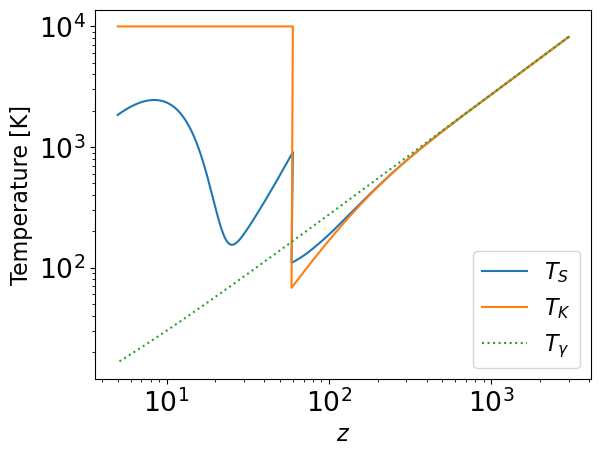

In [6]:
plt.loglog(gs.history['z'], gs.history['igm_Ts'], label=r'$T_S$')
plt.loglog(gs.history['z'], gs.history['igm_Tk'], label=r'$T_K$')
plt.loglog(gs.history['z'], sim.cosm.get_Tcmb(gs.history['z']), ls=':', label=r'$T_{\gamma}$')
plt.xlabel(r'$z$')
plt.ylabel('Temperature [K]')
plt.legend()

Or, you can access convenience routines within the analysis class, which
is inherited by the ``ares.simulations.Global21cm`` instance we've called `gs`:

(<AxesSubplot: xlabel='$\\nu \\ (\\mathrm{MHz})$', ylabel='$\\delta T_b \\ (\\mathrm{mK})$'>,
 <AxesSubplot: xlabel='$z$'>)

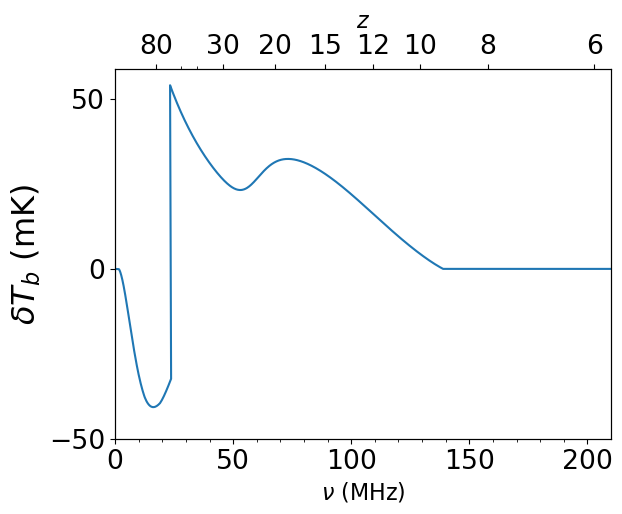

In [7]:
gs.Plot21cmGlobalSignal(fig=2)

If you'd like to save the results to disk, do something like: 

In [8]:
gs.save('test_21cm', clobber=True)

AttributeError: 'dict' object has no attribute '_data'

which saves the contents of ``gs.history`` at all time snapshots to the file ``test_21cm.history.pkl`` and the parameters used in the model in ``test_21cm.parameters.pkl``.

**NOTE:** The default format for output files is ``pkl``, though ASCII (e.g., ``.txt`` or ``.dat``), ``.npz``, and ``.hdf5`` are also supported. Use the optional keyword argument ``suffix``.

If you just want the plot, you can do, e.g.,

In [ ]:
plt.figure(2)
plt.savefig('ares_gs_default.png')

To read results from disk, you can supply a filename *prefix* to ``ares.analysis.Global21cm`` 
rather than a ``ares.simulations.Global21cm`` instance if you'd like, e.g., 

In [ ]:
anl = ares.analysis.Global21cm('test_21cm')

and use this new instance `anl` like we were using `gs` above, e.g.,

In [ ]:
anl.Plot21cmGlobalSignal()

See [built-in analysis routines](../analysis.html) for other options.

See the [parameters list](../params.html) to learn about other parameters that can be supplied
to ``ares.simulations.Global21cm`` as keyword arguments.

## 2-D Parameter Study

To do simple parameter study, you could do something like:

In [ ]:
ax = None
for i, fX in enumerate([0.1, 1.]):
    for j, fstar in enumerate([0.1, 0.5]):
        
        p = pars.copy()
        p['pop_fstar{0}'] = fstar
        p['pop_rad_yield{1}'] = fX * 2.6e39
        sim = ares.simulations.Simulation(verbose=False, progress_bar=False, **p)
        gs = sim.get_21cm_gs()

        # Plot the global signal
        ax, zax = gs.GlobalSignature(ax=ax, fig=3, z_ax=i==j==0,
            label=r'$f_X=%.2g, f_{\ast}=%.2g$' % (fX, fstar))
            
            
ax.legend(loc='lower right', fontsize=14) 

These parameters, along with ``Tmin``, ``Nlw``, and ``Nion`` round out the simplest parameterization of the signal (that I'm aware of) that's tied to cosmology/galaxy formation in any way. It's of course highly simplified, in that it treats galaxies in a very average sense. For more sophisticated models, check out [this example](example_pop_galaxy).
                 
Check out [the listing](../params_populations.html) of the most common parameters that govern the properties of source populations, and [](example_grid) for examples of how to run and analyze large grids of models more easily. The key advantage of using the built-in model grid runner is having *ARES* automatically store any information from each calculation that you deem desirable, and store it in a format amenable to the built-in analysis routines.

## A Note About Backward Compatibility

The models shown in this section are no longer the "best" models in *ARES*, though they may suffice depending on your interests. As alluded to at the end of the previous section, the chief shortcoming of these models is that their parameters are essentially averages over the entire galaxy population, when in reality galaxy properties are known to vary with mass and many other properties.

This was the motivation behind [our paper in 2017](http://adsabs.harvard.edu/abs/2017MNRAS.464.1365M), in which we generalized the star formation efficiency to be a function of halo mass and time, and moved to using stellar population synthesis models to determine the UV emissivity of galaxies, rather than choosing $N_{\mathrm{LW}}$, $N_{\mathrm{ion}}$, etc. by hand (see [More Realistic Galaxy Populations](example_pop_galaxy)). These updates led to a new parameter-naming convention in which all population-specific parameters were given a ``pop_`` prefix. So, in place of ``Nlw``, ``Nion``, ``fX``, now one should set ``pop_rad_yield`` in a particular band (defined by ``pop_Emin`` and ``pop_Emax``). See [the parameter listing for populations](params_populations) for more information about that. 